---
title: Auxiliary Magic
description: Hierarchical regularization via an auxiliary variable magic trick.
date: 7/7/2022
draft: true
bibliography: references.bib
csl: annals_statistics.csl
image: cauchy_canyon.png
format:
  html:
    code-fold: false
---

[Last time](https://jlindbloom.github.io/posts/simple_image_deblurring.html) we looked at an image de-blurring problem, which we solved by finding
$$
x^\star = \text{argmin}_x \,\, \| A x - y \|_2^2 + \mathcal{R}(x)
$${#eq-inv_prob_obj}
where the regularization term was
$$
\mathcal{R}(x) = \gamma \| L x \|_2^2 = \gamma x^T L^T L x.
$$
In this post, our goal is to:
- describe a hierarchical prior and a method that can give us a better image reconstruction,
- walk through a "magic" trick that will speed up our method,
- and look at using [`CuPy`](https://cupy.dev/) to accelerate our reconstruction using a GPU.

# Probabilistic Inverse Problems

While the problem posed in @eq-inv_prob_obj is completely deterministic, we can actually think of it as haven arisen from a probabilistic model. Suppose that
$$
\begin{align*}
x &\sim \mathcal{N}\left( 0, \left(\gamma L^T L \right)^{-1} \right), \\
y \, | \, x &\sim \mathcal{N}\left( A x, I \right).
\end{align*}
$$
Then our corresponding density functions are
$$
\begin{align*}
\pi(x) &\propto \exp\left\{ - \gamma x^T L^T L  x \right\}, \\
\pi(y \, | \, x) &\propto \exp\left\{ - \| A x - y \|_2^2 \right\},
\end{align*}
$$
and by Bayes' theorem the posterior density for $x \, | \, y$ is given as
$$
\pi(x \, | \, y) \propto \exp\left\{ - \| A x - y \|_2^2 \right\} \times \exp\left\{ - \gamma x^T L^T L  x \right\}.
$$
The [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of $x$ is then given as
$$
x^\star = \text{argmax}_x \,\, \pi(x \, | \, y),
$$
which is equivalent to 
$$
\begin{align*}
x^\star &= \text{argmin}_x \,\, - \log \pi(x \, | \, y) \\
&= \text{argmin}_x \,\, \gamma \| L x \|_2^2 = \gamma x^T L^T L x,
\end{align*}
$$
which is exactly @eq-inv_prob_obj. The role of $\mathcal{R}(x)$ can then be seen as contributing a prior of
$$
\pi(x) \propto \exp\left\{ - \mathcal{R}(x) \right\}
$$
into the inference problem. 

# A Hierarchical Prior

One reason it can be useful to think probabilistically is because we can motivate different choices of the regularizer $\mathcal{R}(x)$. If we pick
$$
Lx \sim \mathcal{N}\left(0, \frac{1}{\gamma} I \right)
$$
as our prior (which corresponds to $\mathcal{R}(x) = \gamma x^T L^T L x$), then we are saying that we believe \emph{a priori} that the discrete gradients in our image are distributed according to zero-mean Gaussian with variance $\gamma^{-1}$. We can tweak the strength of the prior by adjusting $\gamma$ and in turn its influence on our reconstructed image, but note that the same $\gamma$ governs \emph{all} of the entire discrete gradient in the image. Thus we might think to introduce a hierarchical prior on the discrete gradient that could try to (loosely) capture the fact that in some regions in an image the discrete gradient will be much larger than it is elsewhere. Define the prior
$$
\begin{align*}
\beta^H_{i,j}, \beta^V_{i,j} &\sim \Gamma \left( c, d \right), \\
L x &\sim \mathcal{N} \left(0, B_{\beta} \right),
\end{align*}
$${#eq-hierarchical_prior}
which has density 
$$
\pi(x, \beta) = \pi(x \, | \, \beta) \pi(\beta) \propto \det \left( B_{\beta} \right)^{1/2} \exp\left\{ - x^T L^T B_{\beta} L x  \right\} \times \pi(\beta).
$$
Here $\left( \cdot \right)^{V/H}$ represent the fact that we are assigining two different hyper-parameter to govern the gradient in each the vertical and horizontal directions, $\Gamma\left(c, d \right)$ represents the [gamma density function](https://en.wikipedia.org/wiki/Gamma_distribution), 
$$
B_{\beta} = \text{diag}\left( \beta^V_{1,1}, \ldots, \beta^V_{m,n}, \beta^H_{1,1}, \ldots, \beta^H_{m,n} \right),
$$
and
$$
\pi(\beta) \propto \left( \prod_{i,j}^{mn} \Gamma( \beta_{i,j}^H | c, d) \right) \times \left( \prod_{i,j}^{mn} \Gamma( \beta_{i,j}^V | c, d) \right)
$$
meaning that all hyper-parameters are assumed to be independent of one another. The reason we use a $\Gamma$ distribution for the hyper-parameter is because it is a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for a Gaussian, meaning that we can determine certain relevant conditional distributions analytically. 

# The New Posterior

Using our prior @eq-hierarchical_prior, the full posterior in our original model (with an extra factor of $\frac{1}{2}$, as well as a noise precision parameter $\alpha$) is given as
$$
\pi(x, \beta \, | \, y) \propto \exp\left\{ - \frac{\alpha}{2} \| A x - y \|_2^2 \right\} \times \det \left( B_{\beta} \right)^{1/2} \exp\left\{ - \frac{1}{2} x^T L^T B_{\beta} L x  \right\} \times \pi(\beta).
$${#eq-hierarchical_posterior}
In the sampling setting, a common approach that could be used to draw samples from this posterior is [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), which involves iteratively drawing from the conditionals of each variable in the density given all of the others. In this case, our conditionals would be
$$
\begin{align*}
\pi(x \, | \, \beta, y) &\propto \exp\left\{- \frac{\alpha}{2}\| A x - y \|_2^2 \right\} \times  \exp\left\{ - x^T L^T B_{\beta} L x  \right\}, \\
\pi(\beta \, | \, x, y) &\propto \det \left( B_{\beta} \right)^{1/2} \exp\left\{ - x^T L^T B_{\beta} L x  \right\} \times \pi(\beta).
\end{align*}
$$
Due to conjugacy, we can recognize the first conditional to be a Gaussian and the second to be a Gamma distribution. Specifically, we have $x \, | \, \beta, y \sim \mathcal{N}\left(\mu_1, Q_1^{-1} \right)$ with
$$
\begin{align*}
Q_1 &= \frac{1}{\alpha} A^T A + L^T B_{\beta} L, \\
\mu_1 &= Q_1^{-1} \left( \frac{1}{\alpha} A^T y \right).
\end{align*}
$$
For $\beta \, | \, x, y$ we have
$$
\begin{align*}
\beta_{i,j} = \Gamma\left( \frac{1}{2} + c, \frac{1}{2}[L x]_{i,j}^2 + d \right),
\end{align*}
$$
where how you deal with $\beta^V$/$\beta^H$ becomes clear when you think about the shapes of these operations.

Rather than code a Gibbs sampling algorithm, we will consider the \emph{Bayesian coordinate descent} (BCD) of [@Glaubitz2022], which is essentially an optimization technique that iteratively draws from the mean of each the conditionals. We iterate
$$
\begin{align*}
x^{k+1} &= \mathbb{E}_{\pi}\left( x \, | \, \beta^k, y \right), \\
\beta^{k+1} &= \mathbb{E}_{\pi}\left( \beta \, | \, x^{k+1}, y \right),
\end{align*}
$$
until the solution converges. One thing to note is that we will generally not settle into a global minimum, since the posterior (with no restrictions on $c$ and $d$) is not log-concave due to the use of a Gamma hyper-prior on the $\beta_{i,j}$.



# An Inconvenience

For the purposes of this post, we will assume that $A$ is a BCCB blurring matrix and that $L$ is an approximation to the discrete gradient with periodic boundary conditions such that $L^T L$ is also BCCB. These were the nice assumptions in the previous post that allowed us to reduce all of our linear system solves to FFTs/IFFs and diagonal matrix operations, as well as efficiently sample in the Fourier domain.  

Note that while we have an analytic expression for the distribution $x \, | \beta, y$, we can no longer use our BCCB assumptions to avoid linear system solves. Letting
$$
\begin{align*}
A &= F^H \Lambda F, \\
L^T L &= F^H \Pi F,
\end{align*}
$$
inserting this into $Q_1^{-1} = \left( A^T A + L^T B_{\beta} L \right)^{-1}$ we now get
$$
\begin{align*}
Q_1^{-1} &= \left( \frac{1}{\alpha} A^T A +  L^T B_{\beta} L \right)^{-1} \\
&= \left( \frac{1}{\alpha} F^H \Lambda F F^H \Lambda F +  L^T B_{\beta} L \right)^{-1} \\
&= \left( \frac{1}{\alpha} F^H \Lambda^2 F +  L^T B_{\beta} L \right)^{-1}  \\
\end{align*}
$$
where unlike before we are now stuck. The problem is that $B_{\beta}$ is "sandwiched" in-between $L^T$ and $L$, which prevents us from using the diagonalization of $L^T L$. While it is not the end of the world to have to solve a linear system using a sparse solver or some other method, we still really would like to use the BCCB assumption to our advantage if we can.


# An Auxiliary Variable Magic Trick

It turns out there is a way to get around this, via a "magic trick" of [@Marnissi2018]. I also discuss this in [this post](https://jlindbloom.github.io/posts/gaussian_posterior_formulas.html) on Gaussian posterior formulas. For the moment let us fix $B_{\beta}$ to be a constant matrix. Out of the blue, define a new random variable via
$$
\begin{align*}
    u \, | \, x, y &\sim \mathcal{N}\left( H x, Q^{-1}  \right),
\end{align*}
$$
where we are free to choose $H$ and $Q$ (as long as they define a valid distribution). Then, if we consider the joint density of $u, x \, | \, y$ we have that 
$$
\begin{align*}
\pi(u, x \, | \, y) &= \pi(u \, | \, x, y) \times \pi(x \, | \, y) \times \pi(x) \\
&\propto \exp\left\{ -\frac{1}{2} \left( H x - u \right)^T Q \left( H x - u \right)  \right\} \times \exp\left\{ -\frac{1}{2} x^T L^T B L x  \right\} \times \pi(x \, | \, y) \\
&\propto \exp\left\{ -\frac{1}{2} \left[ \left( H x - u \right)^T Q \left( H x - u \right) + x^T L^T B L x  \right] \right\} \times \pi(x \, | \, y) \\
&\propto \exp\left\{ -\frac{1}{2} \left[ x^T H^T Q H x + u^T Q u - 2 x^T H^T Q u + x^T L^T B L x  \right] \right\} \times \pi(x \, | \, y) \\
&\propto \exp\left\{ -\frac{1}{2} \left[ x^T P x + u^T Q u - 2 x^T H^T Q u  \right] \right\} \times \pi(x \, | \, y) \\
\end{align*}
$$
where we have defined
$$
P = H^T Q H + L^T B L.
$$
We are free to choose $H$ and $Q$, so let's make the magic choice
$$
\begin{align*}
H &= L, \\
Q &= \frac{1}{\lambda} I  - B.
\end{align*}
$$
Here $\lambda > 0$ is a constant we are free to choose, so long as $\lambda < \frac{1}{\| B \|}$ which makes $Q$ positive semi-definite as is required of a valid precision matrix. Inserting this choice *and conditioning on* $u$, we obtain
$$
P = \frac{1}{\lambda} L^T L
$$
and
$$
\begin{align*}
\pi(x \, | \, u,  y) &\propto \exp\left\{ -\frac{1}{2} \left[ \frac{1}{\lambda} x^T L^T L x - 2 x^T L^T Q u  \right] \right\} \times \pi(x \, | \, y). \\
\end{align*}
$$
Now, we define yet another random variable
$$
v = Qu = \left( \frac{1}{\lambda} I  - B \right) u,
$$
insert into the density above to get
$$
\begin{align*}
\pi(x \, | \, v,  y) &\propto \exp\left\{ -\frac{1}{2} \left[ \frac{1}{\lambda} x^T L^T L x - 2 x^T L^T v \right] \right\} \times \pi(x \, | \, y), \\
\end{align*}
$$
and finally complete the square in the exponential to finally arrive at
$$
\begin{align*}
\pi(x \, | \, v,  y) &\propto \exp\left\{ -\frac{1}{2 \lambda} \| L x - \lambda v  \|_2^2  \right\} \times \pi(x \, | \, y), \\
\end{align*}
$$
which is the density of the Gaussian $\mathcal{N}\left( \mu_2, Q_2^{-1} \right)$ where
$$
\begin{align*}
Q_2 &= \frac{1}{\lambda} L^T L + \frac{1}{\alpha} A^T A, \\
\mu_2 &= Q_2^{-1} \left( \frac{1}{\alpha} A^T y +  L^T \left( \frac{1}{\lambda} I \right) \left( \lambda v \right)  \right) \\
&= Q_2^{-1} \left( \frac{1}{\alpha} A^T y +  L^T  v \right).
\end{align*}
$$
Note that we could do this since the missing term in the square was independent of $x$. Now we have what we wanted: *the matrix* $B$ *has disappeared* after conditioning on $v$, and we can now take advantage of our BCCB assumption for this conditional. This is all only useful so long as the conditional distribution $v \, | \, x, y $ is also nice, which is the Gaussian $\mathcal{N}\left( \mu_3, Q_3^{-1} \right)$ where
$$
\begin{align*}
Q_3^{-1} &= \frac{1}{\lambda} I - B, \\
\mu_3 &= \left( \frac{1}{\lambda} I - B \right) L x,
\end{align*}
$$
which is nice to work with.




# The Augmented Hierarchical Model

It turns out that when we allow $B = B_{\beta}$ to vary with hyper-parameters, everything we just did stays exactly the same, except we must choose a new $\lambda=  \lambda(B_{\beta})$ such that $\lambda < \frac{1}{\| B_\beta \|}$ for the current values of the hyper-parameters. We have already discussed the conditionals $x \, | \, v, \beta, y$ and $v \, | \, x, \beta, y$ which are the same as before, but it turns out that the conditional $\beta \, | \, x, v, y$ is not trivial. As far as I know, this conditional is no longer known directly. So is all of our work for nothing? Fortunately, no, due to a technique called partially collapsed Gibbs sampling (PCGS) [@vanDyk2008PartiallyCG]. Note that while we don't know an analytic form for $\beta \, | \, x, v, y$, we *do* know the form of $\beta \, | \, x, y$ which is the same as it was in the model before we introduced $v$. PCGS is designed to take advantage of this by allowing us to only need access to $\beta \, | \, x, y$, with the price being that the order in which we iterate through the conditionals now matters. 

Thus our discussion leads us to a modified version of the BCD algorithm that uses an auxiliary variable to simplify the calculations for the update of each variable:
$$
\begin{align*}
x^{k+1} &= \mathbb{E}_{\pi}\left( x \, | \, v^k, \beta^k, y \right), \\
v^{k+1} &= \mathbb{E}_{\pi}\left( v \, | \, x^k, \beta^k, y \right), \\
\beta^{k+1} &= \mathbb{E}_{\pi}\left( \beta \, | \, x^{k+1}, y \right).
\end{align*}
$$
We will test this out by building off our code from my [previous post](https://jlindbloom.github.io/posts/simple_image_deblurring.html) on de-blurring.


<!-- 
$\beta \, | \, x, v, y$ which has density
$$
\pi(\beta \, | \, x, v, y) \propto \exp\left\{ - \frac{1}{2} \left( v - B_{\beta} L x \right)^T B_{\beta}^{-1} \left( v - B_{\beta} L x \right) \right\} \times \det \left( B_{\beta} \right)^{1/2} \exp\left\{ - \frac{1}{2} x^T L^T B_{\beta} L x  \right\} \times \pi(\beta).
$$
However, we can determine this by just updating the gamma hyper-prior twice so that this conditional is -->

# The code

The first thing we will do is some initial set-up for the problem such as setting up our differencing matrix and computing the diagonalizations of $A$ and $L^T L$. We will use the same blurred image from the previous post.

In [3]:
%%capture

import numpy as np
import scipy.sparse as sp
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageOps


# Load blurred image
blurred_img = Image.open("blurred_grand_canyon.jpg")
blurred_img = ImageOps.grayscale(blurred_img)
blurred_img = np.asarray(blurred_img)
blurred_img = blurred_img/255
M, N = blurred_img.shape


# Define blur operator using sigma
blur_sigma = 20.0
blur_op = lambda x: gaussian_filter(x, blur_sigma, mode='wrap')


# Compute diagonalization for the blurring operator
rand_img = np.random.randn(M,N)
mat_prod_rand_img = np.fft.fft2(blur_op(np.fft.ifft2(rand_img, norm='ortho')), norm='ortho')
lam = mat_prod_rand_img/rand_img
lam = np.real(lam) # We know it should be real
lam_inv = 1/lam


# Construct our differencing matrices
d_mat_vert = sp.eye(N)
d_mat_vert.setdiag(-1,k=-1)
d_mat_vert = sp.csc_matrix(d_mat_vert)
d_mat_vert[0,-1] = -1 # For periodic BCs
eye_horiz = sp.eye(M)
d_mat_one = sp.kron(eye_horiz, d_mat_vert)

d_mat_horiz = sp.eye(M)
d_mat_horiz.setdiag(-1,k=-1)
d_mat_horiz = sp.csc_matrix(d_mat_horiz)
d_mat_horiz[0,-1] = -1 # For periodic BCs
eye_vert = sp.eye(N)
d_mat_two = sp.kron(d_mat_horiz, eye_vert)


# Make L, L^T, and L^T L
L = sp.vstack([d_mat_one, d_mat_two])
Lt = L.T
LtL = Lt @ L 


# Next, we need to compute $\Pi$ like we did earlier with $\Lambda$.
rand_img = np.random.randn(M,N)
mat_prod_rand_img = np.fft.fft2( (LtL @ np.fft.ifft2(rand_img, norm='ortho').flatten() ).reshape((M,N)), norm='ortho')
pi = mat_prod_rand_img/rand_img
pi = np.real(pi) # We know it should be real
pi_inv = 1/pi


In order to quickly perform the FFTs/IFFTs needed for the algorithm, we will leverage a GPU via [`CuPy`](https://cupy.dev/). I had previously tried doing this algorithm on CPUs with just NumPy alone and found that it took about one iteration per second, whereas with CuPy we can get about 500 iterations per 30 seconds (about 17 iterations per second).

In terms of NumPy vs. CuPy, the main things to keep in mind are that 
1. you must explicitly transfer arrays between the CPU and GPU, and
2. while on the GPU, you must use functions that act on CuPy arrays.

Both of these are easy to do. For this post, I will suffix all arrays that live on the GPU with `_gpu`. Let's bring all of the things we just computed onto the GPU:

In [4]:
import cupy as cp

# Bring diagonalizations Pi and Lambda onto GPU
pi_gpu = cp.asarray(pi)
lam_gpu = cp.asarray(lam)

# Bring L, Lt, and LtL onto the GPU
L_gpu = cp.sparse.csc_matrix(L)
Lt_gpu = cp.sparse.csc_matrix(Lt)
LtL_gpu = cp.sparse.csc_matrix(LtL)

Note that [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) matrices are different from [`cupy.sparse`](https://docs.cupy.dev/en/stable/reference/scipy_sparse.html) matrices, and that we bring them onto the GPU by calling the CuPy constructor on the SciPy (CPU) version of the matrix.

To apply our blurring operator to a vector on the GPU, we will also need to use the CuPy version of `gaussian_filter`:

In [6]:
from cupyx.scipy.ndimage import gaussian_filter as cupy_gaussian_filter 

blur_op_gpu = lambda x: cupy_gaussian_filter(x, blur_sigma, mode='wrap')

Let's make our arrays for $x$, $v$, $y$, and $\beta$:

In [207]:
x_gpu = cp.asarray(blurred_img) # Start x at the observed image
y_gpu = cp.asarray(blurred_img) # The observation
v_gpu = cp.asarray( L @ blurred_img.flatten() ) # Start v at Lx, this gives it the correct shape
betas_gpu = 10*cp.ones(2*M*N)

Remember that we need to pick a new value of $\lambda$ each time we update $\beta$. We will make the choice
$$
\lambda(\beta) = \frac{1}{2}\left( \frac{1}{\| B_{\beta} \|} + 0\right),
$$
which should be half of the maximum value we would be allowed to pick for $\lambda$. I am not sure how picking $\lambda$ on the high or low side affects the performance, but I would guess that higher is better. In our code, I will refer to this $\lambda$ as `lam_aux`.

In [208]:
lam_aux = ((1/cp.amax(betas)) + 0)/2

We also need to set some noise precision $\alpha = \sigma^{-2}$, and we can go ahead and pre-compute $\frac{1}{\alpha} A^T y$ which shows up in our formula for the conditional for $x$.

In [209]:
noise_sigma = 0.01
noise_prec = 1/(noise_sigma**2)
Aty_gpu = noise_prec*blur_op_gpu(y_gpu)

And finally, we must select the hyper-hyper-parametes $c$ and $d$. We will examine two choices, the first being the "uniformative" choice
$$
\begin{align*}
c &= 1.0, \\
d &= 10^{-20},
\end{align*}
$$
which corresponds to a flat prior.

In [210]:
c = 1.0
d = 1e-12

Now we are ready to perform the BCD algorithm for the reconstruction of $x$ from $y$. I will not go into the details, as all of the operations are just the implementation of the steps we outlined earlier.

In [211]:
from fastprogress import progress_bar

# Set some number of iterations
n_iterations = 500

# Now do BCD
for j in progress_bar(range(n_iterations)):
    
    ### Update x
    Ltv_gpu = ( Lt_gpu @ v_gpu ).reshape((M,N))
    b = Aty_gpu + Ltv_gpu
    mu_x = cp.fft.fft2( b, norm='ortho')
    diag_fourier_vec = 1/( (1/lam_aux)*(pi_gpu) + (noise_prec)*(lam_gpu**2) )
    mu_x = diag_fourier_vec*mu_x
    mu_x = cp.real(cp.fft.ifft2(mu_x, norm='ortho'))
    x_gpu = mu_x
    
    ### Update betas
    gamma_alpha = c + 0.5
    gamma_beta = 0.5*( ( L_gpu @ x_gpu.flatten() )**2) + d 
    betas_gpu = gamma_alpha/gamma_beta

    ### Update lam_aux
    lam_aux = ( (1/cp.amax(betas_gpu) ) + 0)/2
    
    # Make sure that this is always true
    assert np.all((1/lam_aux) - betas_gpu > 0), "invalid choice of lam_aux was made"
    
    ### Update v
    v_gpu = ( (1/lam_aux) - betas_gpu )*( L_gpu @ x_gpu.flatten() )
    
# Bring arrays back to the cpu
x = cp.asnumpy(x_gpu)
v = cp.asnumpy(v_gpu)
betas = cp.asnumpy(betas_gpu)

Let's look at the reconstruction, as well as $\beta$. Here I have plotted the `betas` on an inverse scale, so brighter pixels should correspond to a higher variance parameter. I have also artificially clipped the array to its 95th percentile, since there are some extremely large precision values that make the entire plot monotone.

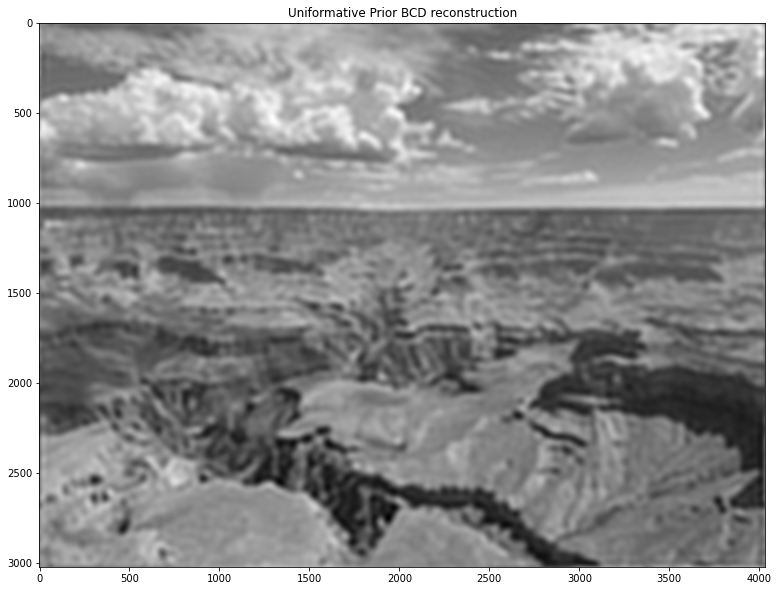

In [212]:
import matplotlib.pyplot as plt

plot_name = "uninformative_prior"
plot_which = "Uniformative Prior"

plt.figure(figsize=(13,13))
plt.imshow(np.real(x), cmap='gray')
plt.title(plot_which + " " + "BCD reconstruction")
plt.show()

In [213]:
betas = betas.reshape((2,M,N))
betas_one, betas_two = betas[0,:,:], betas[1,:,:]

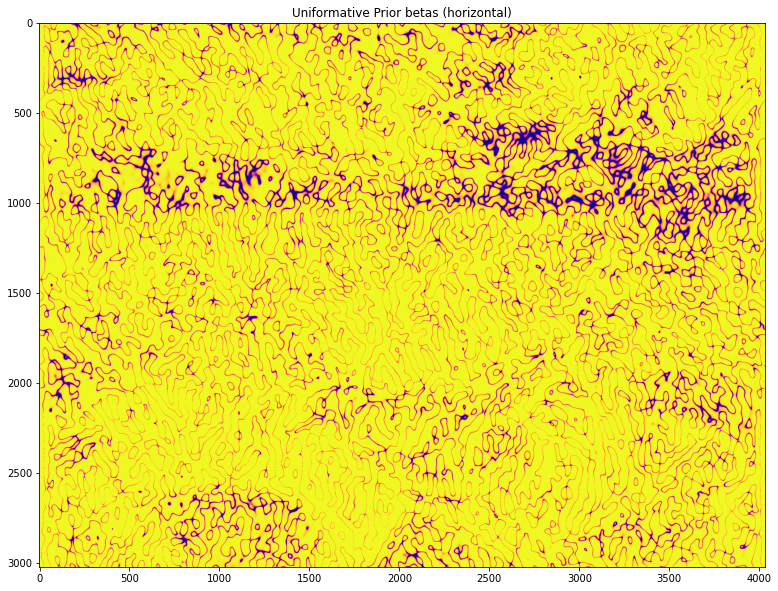

In [214]:
plt.figure(figsize=(13,13))
plt.imshow(np.clip(betas_one, a_min=None, a_max = np.quantile(betas_one.flatten(), 0.95)), cmap='plasma_r')
plt.title(plot_which + " " + "betas (horizontal)")
plt.show()

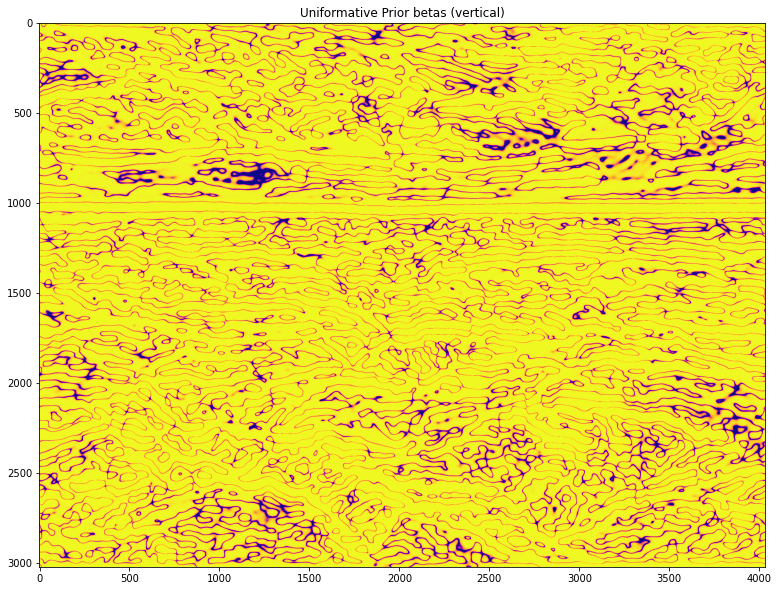

In [215]:
plt.figure(figsize=(13,13))
plt.imshow(np.clip(betas_two, a_min=None, a_max = np.quantile(betas_two.flatten(), 0.95)), cmap='plasma_r')
plt.title(plot_which + " " + "betas (vertical)")
plt.show()

Notice how you can (somewhat) trace out some of the edges in the image by the inferred variance parameters. Here is a comparison of the original, blurred, and reconstructed images:

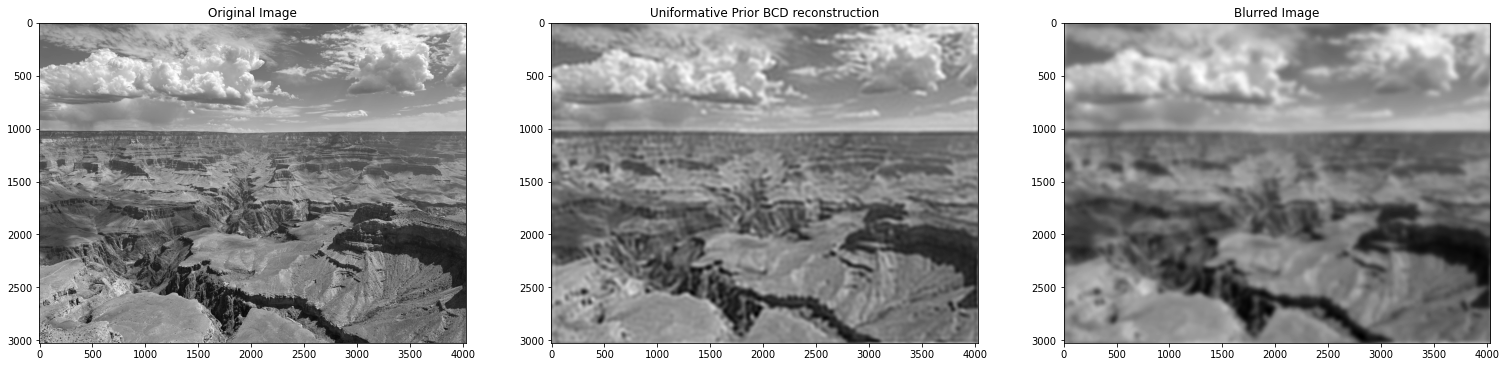

In [217]:
# Load original image
img = Image.open("grand_canyon.jpg")
img = ImageOps.grayscale(img)
img = np.asarray(img)
img = img/255

fig, axs = plt.subplots(1, 3, figsize=(26,26))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(np.real(x), cmap='gray')
axs[1].set_title(plot_which + " " + "BCD reconstruction")
axs[2].imshow(blurred_img, cmap='gray')
axs[2].set_title("Blurred Image")

plt.show()

The last thing I will point out is that by changing the $c$ and $d$ hyper-hyper-parameters, you can change the degree of sparsity in the prior on $L x$. As we did in a [previous post](https://jlindbloom.github.io/posts/hierarchical_cmrf.html), we can recover a prior that is marginally Cauchy with a special choice of $c$ and $d$. Let's repeat the reconstruction with the choice
$$
\begin{align*}
c &= 0.5, \\
d &= 0.5(0.0005^2).
\end{align*}
$$

In [220]:
noise_sigma = 0.01
c = 0.5
d = 0.5*(0.0005**2)

x_gpu = cp.asarray(blurred_img) # Start x at the observed image
y_gpu = cp.asarray(blurred_img) # The observation
v_gpu = cp.asarray( L @ blurred_img.flatten() ) # Start v at Lx, this gives it the correct shape
betas = 10*cp.ones(2*M*N)

lam_aux = ((1/cp.amax(betas)) + 0)/2

In [221]:
# Set some number of iterations
n_iterations = 500

# Now do BCD
for j in progress_bar(range(n_iterations)):
    
    ### Update x
    Ltv_gpu = ( Lt_gpu @ v_gpu ).reshape((M,N))
    b = Aty_gpu + Ltv_gpu
    mu_x = cp.fft.fft2( b, norm='ortho')
    diag_fourier_vec = 1/( (1/lam_aux)*(pi_gpu) + (noise_prec)*(lam_gpu**2) )
    mu_x = diag_fourier_vec*mu_x
    mu_x = cp.real(cp.fft.ifft2(mu_x, norm='ortho'))
    x_gpu = mu_x
    
    ### Update betas
    gamma_alpha = c + 0.5
    gamma_beta = 0.5*( ( L_gpu @ x_gpu.flatten() )**2) + d 
    betas_gpu = gamma_alpha/gamma_beta

    ### Update lam_aux
    lam_aux = ( (1/cp.amax(betas_gpu) ) + 0)/2
    
    # Make sure that this is always true
    assert np.all((1/lam_aux) - betas_gpu > 0), "invalid choice of lam_aux was made"
    
    ### Update v
    v_gpu = ( (1/lam_aux) - betas_gpu )*( L_gpu @ x_gpu.flatten() )
    
# Bring arrays back to the cpu
x = cp.asnumpy(x_gpu)
v = cp.asnumpy(v_gpu)
betas = cp.asnumpy(betas_gpu)

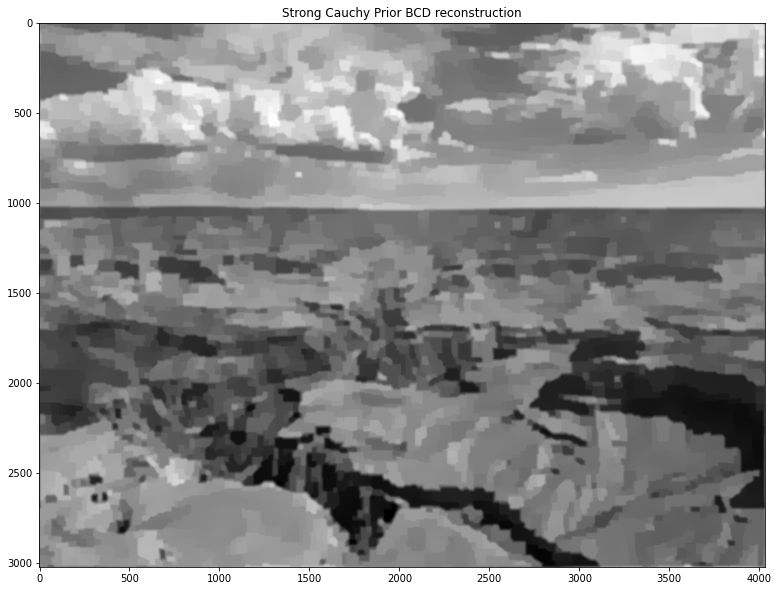

In [222]:
plot_name = "strong_cauchy_prior"
plot_which = "Strong Cauchy Prior"

plt.figure(figsize=(13,13))
plt.imshow(np.real(x), cmap='gray')
plt.title(plot_which + " " + "BCD reconstruction")
plt.show()

In [223]:
betas = betas.reshape((2,M,N))
betas_one, betas_two = betas[0,:,:], betas[1,:,:]

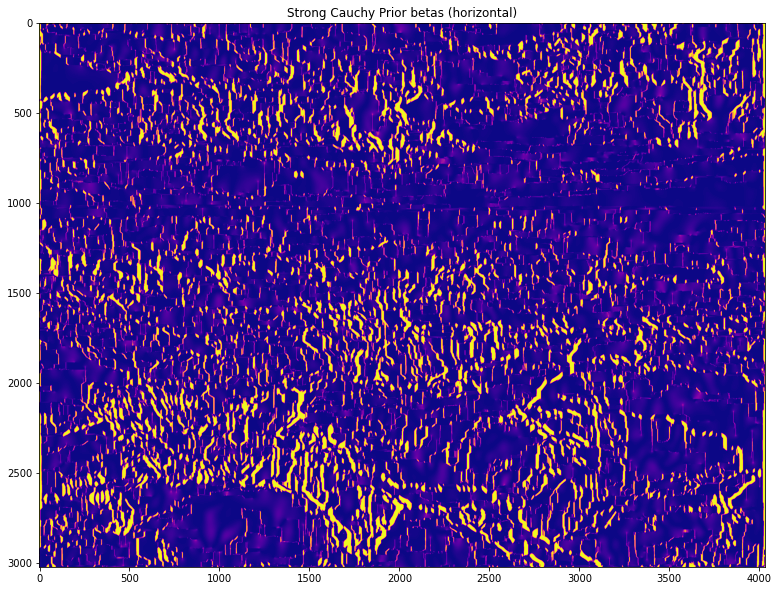

In [224]:
plt.figure(figsize=(13,13))
plt.imshow(np.clip(betas_one, a_min=None, a_max = np.quantile(betas_one.flatten(), 0.95)), cmap='plasma_r')
plt.title(plot_which + " " + "betas (horizontal)")
plt.show()

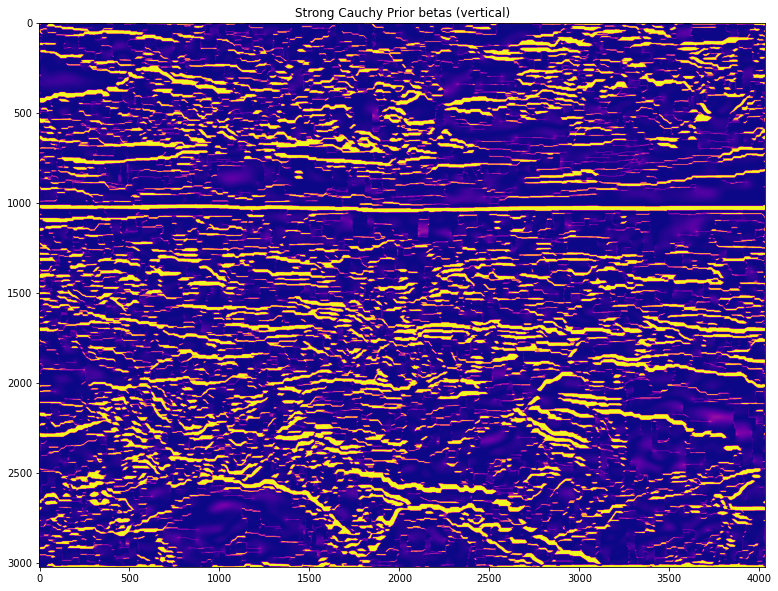

In [225]:
plt.figure(figsize=(13,13))
plt.imshow(np.clip(betas_two, a_min=None, a_max = np.quantile(betas_two.flatten(), 0.95)), cmap='plasma_r')
plt.title(plot_which + " " + "betas (vertical)")
plt.show()

In [226]:
#plt.figure(figsize=(13,13))
plt.imsave("cauchy_canyon.png", np.clip(betas_two, a_min=None, a_max = np.quantile(betas_two.flatten(), 0.95)), cmap='plasma_r')
#plt.title(plot_which + " " + "betas (vertical)")
#plt.show()

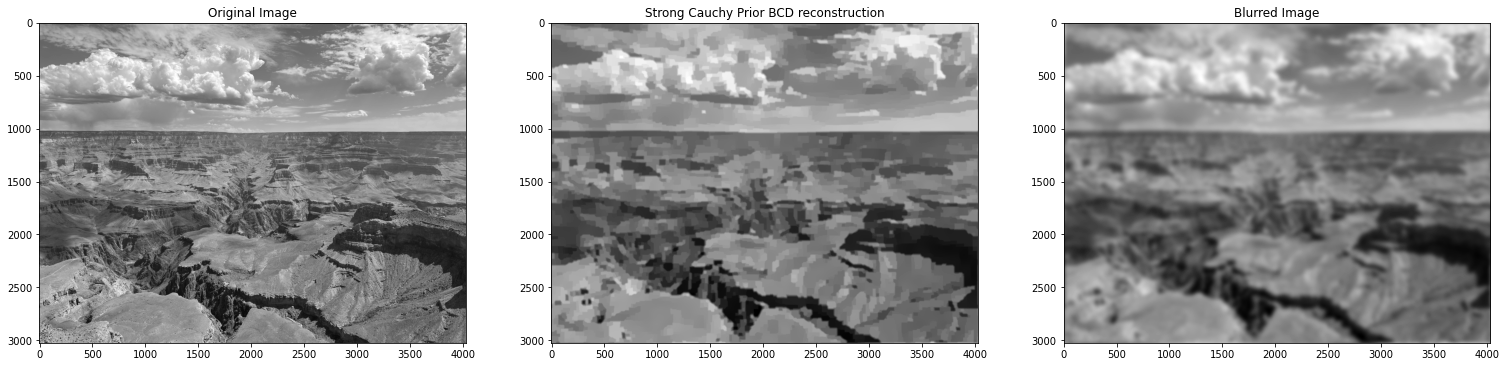

In [227]:
fig, axs = plt.subplots(1, 3, figsize=(26,26))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(np.real(x), cmap='gray')
axs[1].set_title(plot_which + " " + "BCD reconstruction")
axs[2].imshow(blurred_img, cmap='gray')
axs[2].set_title("Blurred Image")

plt.show()